[![Binder](https://mybinder.org/badge_logo.svg)](https://mybinder.org/v2/gh/atmos-cloud-sim-uj/PySDM.git/master?filepath=PySDM_tutorials/environments/parcel.ipynb)
  
[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/atmos-cloud-sim-uj/PySDM/blob/master/PySDM_tutorials/environments/parcel.ipynb)

In [1]:
"""
clone and install PySDM dependencies in Colab
(to use GPU on Colab set hardware accelerator to 'GPU' before session start
in the "Runtime :: Change runtime type :: Hardware accelerator" menu)
"""
import os, sys
if 'google.colab' in sys.modules:
    %cd /content
    if not os.path.isdir('PySDM'):
        !git clone --depth 1 https://github.com/atmos-cloud-sim-uj/PySDM.git
    %cd PySDM
    !pip install -r requirements.txt

In [2]:
import os, sys
if 'google.colab' in sys.modules:
    %cd /content/PySDM
else:
    sys.path.insert(0, os.path.join(os.getcwd(), '../..'))

In [3]:
import numpy as np

from PySDM.physics import si
from PySDM.initialisation import spectral_sampling
from PySDM.initialisation import multiplicities
from PySDM.initialisation.spectra import Lognormal
from PySDM.backends import CPU
from PySDM import Builder
from PySDM.dynamics import AmbientThermodynamics
from PySDM.dynamics import Condensation
from PySDM.environments import Parcel
from PySDM.physics import formulae as phys
from PySDM.initialisation.r_wet_init import r_wet_init
from PySDM.products import ParticleMeanRadius, RelativeHumidity, CloudConcentration

builder = Builder(backend=CPU, n_sd=1)
environment = Parcel(
    dt=1 * si.s,
    mass_of_dry_air=1 * si.kg,
    p0=1000 * si.hPa,
    q0=20 * si.g / si.kg,
    T0=300 * si.K,
    w= 1 * si.m / si.s
)
builder.set_environment(environment)

kappa = 1 * si.dimensionless
builder.add_dynamic(AmbientThermodynamics())
builder.add_dynamic(Condensation(kappa=kappa))

attributes = {}
r_dry, specific_concentration = spectral_sampling.Logarithmic(
            spectrum=Lognormal(
                norm_factor=1000 / si.milligram,
                m_mode=50 * si.nanometre,
                s_geom=1.4 * si.dimensionless
            ),
            size_range=(10.633 * si.nanometre, 513.06 * si.nanometre)
        ).sample(n_sd=builder.core.n_sd)
attributes['dry volume'] = phys.volume(radius=r_dry)
attributes['n'] = multiplicities.discretise_n(specific_concentration * environment.mass_of_dry_air)
r_wet = r_wet_init(r_dry, environment, np.zeros_like(attributes['n']), kappa)
attributes['volume'] = phys.volume(radius=r_wet)

products = [ParticleMeanRadius(), RelativeHumidity(), CloudConcentration(radius_range=(.5 * si.um, 25 * si.um))]

core = builder.build(attributes, products)
output = {product.name: [product.get()[0]] for product in core.products.values()}
output['z'] = [environment['z'][0]]

for step in range(100):
    core.run(steps=10)
    for product in core.products.values():
        output[product.name].append(product.get()[0])
    output['z'].append(environment['z'][0])

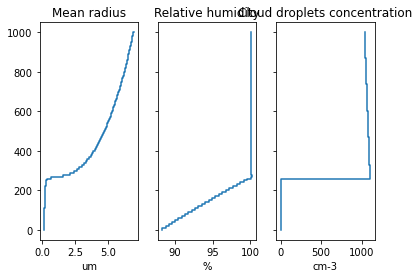

In [4]:
from matplotlib import pyplot

fig, axs = pyplot.subplots(1, len(core.products), sharey="all")
for i, (key, product) in enumerate(core.products.items()):
    axs[i].step(output[key], output['z'])
    axs[i].set_title(product.description)
    axs[i].set_xlabel(product.unit)